In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Default.csv', index_col=0)

In [3]:
df

default student      balance        income
1          No      No   729.526495  44361.625074
2          No     Yes   817.180407  12106.134700
3          No      No  1073.549164  31767.138947
4          No      No   529.250605  35704.493935
5          No      No   785.655883  38463.495879
...       ...     ...          ...           ...
9996       No      No   711.555020  52992.378914
9997       No      No   757.962918  19660.721768
9998       No      No   845.411989  58636.156984
9999       No      No  1569.009053  36669.112365
10000      No     Yes   200.922183  16862.952321

[10000 rows x 4 columns]

In [4]:
df.iloc[:,1:]

student      balance        income
1          No   729.526495  44361.625074
2         Yes   817.180407  12106.134700
3          No  1073.549164  31767.138947
4          No   529.250605  35704.493935
5          No   785.655883  38463.495879
...       ...          ...           ...
9996       No   711.555020  52992.378914
9997       No   757.962918  19660.721768
9998       No   845.411989  58636.156984
9999       No  1569.009053  36669.112365
10000     Yes   200.922183  16862.952321

[10000 rows x 3 columns]

In [5]:
df.student = df.student.map(dict(Yes=1, No=0))

In [6]:
#df[df.default.isna()]
df

default  student      balance        income
1          No        0   729.526495  44361.625074
2          No        1   817.180407  12106.134700
3          No        0  1073.549164  31767.138947
4          No        0   529.250605  35704.493935
5          No        0   785.655883  38463.495879
...       ...      ...          ...           ...
9996       No        0   711.555020  52992.378914
9997       No        0   757.962918  19660.721768
9998       No        0   845.411989  58636.156984
9999       No        0  1569.009053  36669.112365
10000      No        1   200.922183  16862.952321

[10000 rows x 4 columns]

In [6]:
# Convert default to binary encoding
df['default_binary'] = df['default'].map({'Yes': 1, 'No': 0})

# Create train-test split
X = df[['student', 'balance', 'income']]
y = df['default_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Class distribution in training set:\n{y_train.value_counts()}")
print(f"Class distribution in test set:\n{y_test.value_counts()}")

Training set size: 8000
Test set size: 2000
Class distribution in training set:
default_binary
0    7734
1     266
Name: count, dtype: int64
Class distribution in test set:
default_binary
0    1933
1      67
Name: count, dtype: int64


In [8]:
len(X_train)

8000

In [9]:
len(X_test)

2000

# Credit Default Analysis with Threshold Optimization

This notebook demonstrates how **probability thresholds** affect the performance of a logistic regression model for credit default prediction.

## Key Concepts:
- **Threshold**: The probability cutoff used to convert predicted probabilities to binary predictions
- **Default threshold**: 0.5 (but this may not be optimal!)
- **Trade-offs**: Lower thresholds catch more defaults but create more false alarms

## Analysis Structure:
1. **Data Exploration**: Understanding the credit default dataset
2. **Model Training**: Logistic regression on customer features
3. **Threshold Analysis**: Testing multiple probability thresholds (0.1 to 0.9)
4. **Performance Visualization**: Seeing how metrics change with threshold
5. **Business Impact**: Understanding costs and benefits of different thresholds

---

## Explore Your Data

<Axes: xlabel='income', ylabel='Count'>

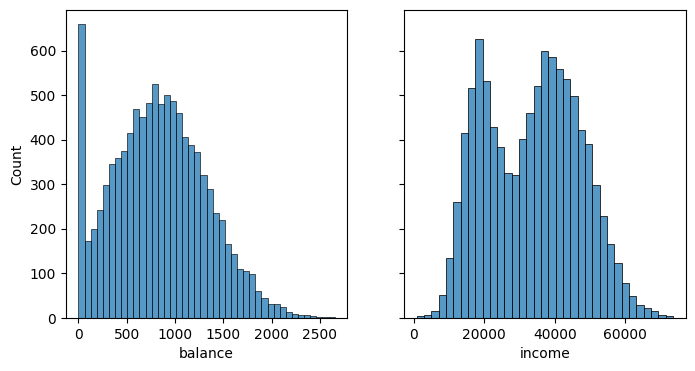

In [7]:
f, ax = plt.subplots(1, 2, figsize = (8,4), sharey= True)
sns.histplot(df.balance,ax = ax[0])
sns.histplot(df.income, ax= ax[1])

<Axes: xlabel='student', ylabel='balance'>

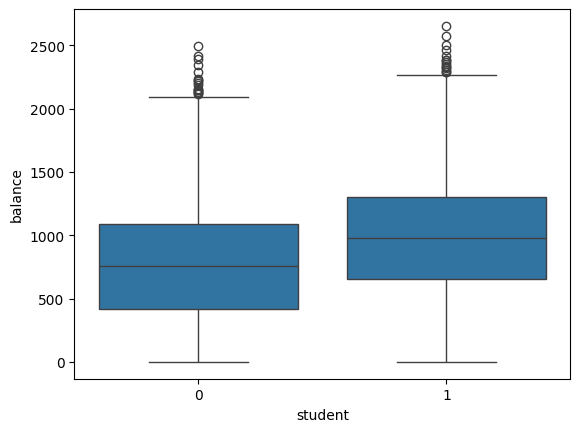

In [8]:
sns.boxplot(x=df.student, y=df.balance)

<Axes: xlabel='default', ylabel='income'>

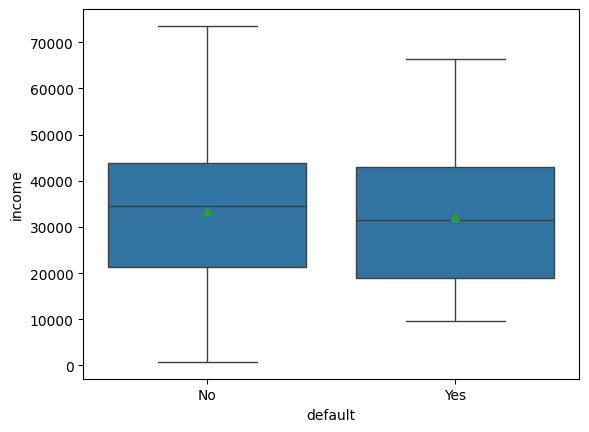

In [9]:
sns.boxplot(x=df.default, y=df.income, showmeans=True)

<Axes: xlabel='balance', ylabel='default'>

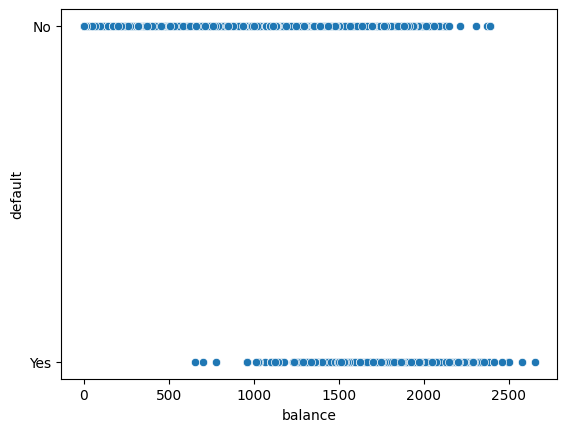

In [10]:
sns.scatterplot(x = df.balance, y = df.default )

<Axes: xlabel='balance', ylabel='income'>

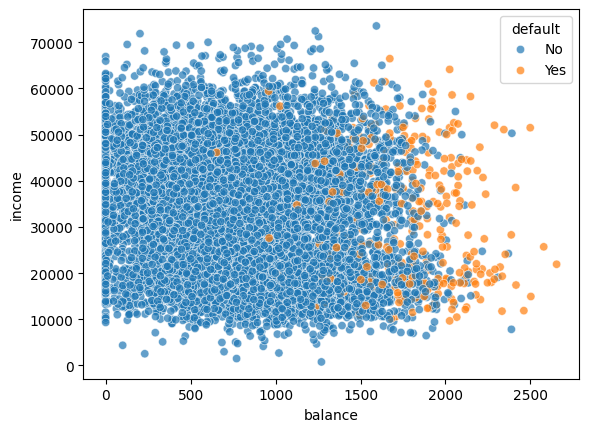

In [11]:
sns.scatterplot(x = df.balance, y = df.income, hue = df.default,alpha = .7 )

In [12]:
# Train Logistic Regression model
logistic = LogisticRegression(random_state=42, max_iter=1000)
logistic.fit(X_train, y_train)

# Get predicted probabilities
y_prob = logistic.predict_proba(X_test)[:, 1]

print("Logistic Regression Model Trained Successfully!")
print(f"Model coefficients: {logistic.coef_[0]}")
print(f"Model intercept: {logistic.intercept_[0]}")
print(f"Feature names: {X_train.columns.tolist()}")

Logistic Regression Model Trained Successfully!
Model coefficients: [-6.06191647e-01  5.71274793e-03 -1.71262697e-06]
Model intercept: -10.667191271535934
Feature names: ['student', 'balance', 'income']


In [14]:
# Comprehensive Threshold Analysis
def evaluate_threshold(y_true, y_prob, threshold):
    """Evaluate model performance at a given threshold"""
    y_pred = (y_prob >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'tn': tn,
        'fn': fn,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0
    }

# Test multiple thresholds
thresholds = np.arange(0.1, 1.0, 0.05)
results = [evaluate_threshold(y_test, y_prob, t) for t in thresholds]

# Convert to DataFrame for easy analysis
threshold_df = pd.DataFrame(results)
print("Threshold Analysis Complete!")
print(f"Tested {len(thresholds)} different thresholds from {thresholds[0]:.2f} to {thresholds[-1]:.2f}")
threshold_df

Threshold Analysis Complete!
Tested 18 different thresholds from 0.10 to 0.95


threshold  accuracy  precision    recall        f1  tp   fp    tn  fn  \
0        0.10    0.9305   0.300000  0.805970  0.437247  54  126  1807  13   
1        0.15    0.9440   0.335766  0.686567  0.450980  46   91  1842  21   
2        0.20    0.9550   0.392523  0.626866  0.482759  42   65  1868  25   
3        0.25    0.9600   0.426966  0.567164  0.487179  38   51  1882  29   
4        0.30    0.9670   0.507042  0.537313  0.521739  36   35  1898  31   
5        0.35    0.9685   0.534483  0.462687  0.496000  31   27  1906  36   
6        0.40    0.9690   0.551020  0.402985  0.465517  27   22  1911  40   
7        0.45    0.9715   0.638889  0.343284  0.446602  23   13  1920  44   
8        0.50    0.9725   0.700000  0.313433  0.432990  21    9  1924  46   
9        0.55    0.9725   0.714286  0.298507  0.421053  20    8  1925  47   
10       0.60    0.9720   0.761905  0.238806  0.363636  16    5  1928  51   
11       0.65    0.9710   0.736842  0.208955  0.325581  14    5  1928  53   
12       0.70    0.9715   0.812500  0.194030  0.313253  13    3  1930  54   
13       0.75    0.9700   0.888889  0.119403  0.210526   8    1  1932  59   
14       0.80    0.9675   0.750000  0.044776  0.084507   3    1  1932  64   
15       0.85    0.9670   0.666667  0.029851  0.057143   2    1  1932  65   
16       0.90    0.9670   1.000000  0.014925  0.029412   1    0  1933  66   
17       0.95    0.9665   0.000000  0.000000  0.000000   0    0  1933  67   

    specificity  
0      0.934816  
1      0.952923  
2      0.966374  
3      0.973616  
4      0.981893  
5      0.986032  
6      0.988619  
7      0.993275  
8      0.995344  
9      0.995861  
10     0.997413  
11     0.997413  
12     0.998448  
13     0.999483  
14     0.999483  
15     0.999483  
16     1.000000  
17     1.000000

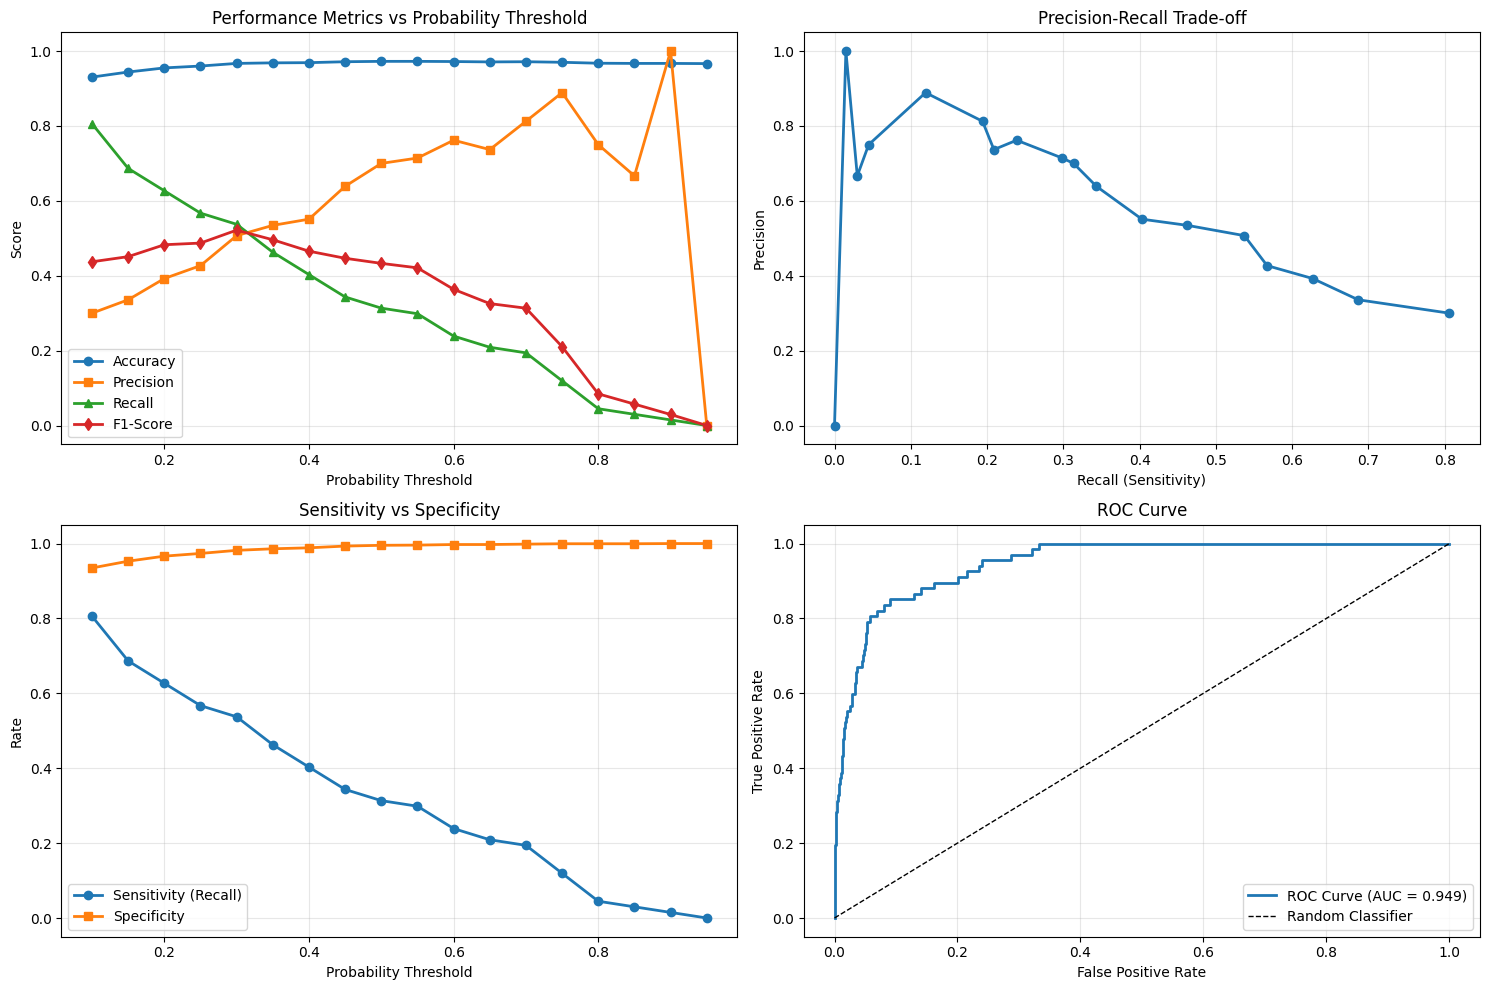

In [15]:
# Visualize Performance Metrics vs Threshold
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Main performance metrics
axes[0, 0].plot(threshold_df['threshold'], threshold_df['accuracy'], 'o-', label='Accuracy', linewidth=2)
axes[0, 0].plot(threshold_df['threshold'], threshold_df['precision'], 's-', label='Precision', linewidth=2)
axes[0, 0].plot(threshold_df['threshold'], threshold_df['recall'], '^-', label='Recall', linewidth=2)
axes[0, 0].plot(threshold_df['threshold'], threshold_df['f1'], 'd-', label='F1-Score', linewidth=2)
axes[0, 0].set_xlabel('Probability Threshold')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Performance Metrics vs Probability Threshold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Precision vs Recall trade-off
axes[0, 1].plot(threshold_df['recall'], threshold_df['precision'], 'o-', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Recall (Sensitivity)')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Trade-off')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Sensitivity vs Specificity
axes[1, 0].plot(threshold_df['threshold'], threshold_df['recall'], 'o-', label='Sensitivity (Recall)', linewidth=2)
axes[1, 0].plot(threshold_df['threshold'], threshold_df['specificity'], 's-', label='Specificity', linewidth=2)
axes[1, 0].set_xlabel('Probability Threshold')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_title('Sensitivity vs Specificity')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
axes[1, 1].plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Compare Performance at Key Thresholds
key_thresholds = [0.3, 0.5, 0.7]

print("="*80)
print("DETAILED COMPARISON OF KEY THRESHOLDS")
print("="*80)

for threshold in key_thresholds:
    y_pred_thresh = (y_prob >= threshold).astype(int)
    
    print(f"\n📊 THRESHOLD = {threshold}")
    print("-" * 40)
    
    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_thresh)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nConfusion Matrix:")
    print(f"True Negatives:  {tn:4d} | False Positives: {fp:4d}")
    print(f"False Negatives: {fn:4d} | True Positives:  {tp:4d}")
    
    # Business interpretation
    total_predictions = len(y_test)
    print(f"\nBusiness Impact:")
    print(f"• Out of {total_predictions} customers:")
    print(f"  - Correctly identified non-defaulters: {tn} ({tn/total_predictions*100:.1f}%)")
    print(f"  - Correctly identified defaulters: {tp} ({tp/total_predictions*100:.1f}%)")
    print(f"  - Missed defaulters (false negatives): {fn} ({fn/total_predictions*100:.1f}%)")
    print(f"  - False alarms (false positives): {fp} ({fp/total_predictions*100:.1f}%)")

print("\n" + "="*80)

DETAILED COMPARISON OF KEY THRESHOLDS

📊 THRESHOLD = 0.3
----------------------------------------
Accuracy:  0.9670
Precision: 0.5070
Recall:    0.5373
F1-Score:  0.5217

Confusion Matrix:
True Negatives:  1898 | False Positives:   35
False Negatives:   31 | True Positives:    36

Business Impact:
• Out of 2000 customers:
  - Correctly identified non-defaulters: 1898 (94.9%)
  - Correctly identified defaulters: 36 (1.8%)
  - Missed defaulters (false negatives): 31 (1.6%)
  - False alarms (false positives): 35 (1.8%)

📊 THRESHOLD = 0.5
----------------------------------------
Accuracy:  0.9725
Precision: 0.7000
Recall:    0.3134
F1-Score:  0.4330

Confusion Matrix:
True Negatives:  1924 | False Positives:    9
False Negatives:   46 | True Positives:    21

Business Impact:
• Out of 2000 customers:
  - Correctly identified non-defaulters: 1924 (96.2%)
  - Correctly identified defaulters: 21 (1.1%)
  - Missed defaulters (false negatives): 46 (2.3%)
  - False alarms (false positives): 9 (0

In [17]:
# Find Optimal Thresholds Based on Different Criteria
print("🎯 OPTIMAL THRESHOLD ANALYSIS")
print("="*60)

# Find optimal thresholds for different objectives
optimal_accuracy = threshold_df.loc[threshold_df['accuracy'].idxmax()]
optimal_f1 = threshold_df.loc[threshold_df['f1'].idxmax()]
optimal_precision = threshold_df.loc[threshold_df['precision'].idxmax()]
optimal_recall = threshold_df.loc[threshold_df['recall'].idxmax()]

# Youden's J statistic (sensitivity + specificity - 1)
threshold_df['youden_j'] = threshold_df['recall'] + threshold_df['specificity'] - 1
optimal_youden = threshold_df.loc[threshold_df['youden_j'].idxmax()]

print(f"🎯 Best Accuracy:  Threshold = {optimal_accuracy['threshold']:.3f}, Accuracy = {optimal_accuracy['accuracy']:.4f}")
print(f"🎯 Best F1-Score:  Threshold = {optimal_f1['threshold']:.3f}, F1 = {optimal_f1['f1']:.4f}")
print(f"🎯 Best Precision: Threshold = {optimal_precision['threshold']:.3f}, Precision = {optimal_precision['precision']:.4f}")
print(f"🎯 Best Recall:    Threshold = {optimal_recall['threshold']:.3f}, Recall = {optimal_recall['recall']:.4f}")
print(f"🎯 Best Balance:   Threshold = {optimal_youden['threshold']:.3f}, Youden's J = {optimal_youden['youden_j']:.4f}")

print(f"\n📈 THRESHOLD RECOMMENDATIONS:")
print(f"• Conservative (minimize false alarms): Use threshold = {optimal_precision['threshold']:.3f}")
print(f"• Aggressive (catch all defaults): Use threshold = {optimal_recall['threshold']:.3f}")
print(f"• Balanced approach: Use threshold = {optimal_f1['threshold']:.3f}")
print(f"• Default sklearn threshold: 0.500")

🎯 OPTIMAL THRESHOLD ANALYSIS
🎯 Best Accuracy:  Threshold = 0.500, Accuracy = 0.9725
🎯 Best F1-Score:  Threshold = 0.300, F1 = 0.5217
🎯 Best Precision: Threshold = 0.900, Precision = 1.0000
🎯 Best Recall:    Threshold = 0.100, Recall = 0.8060
🎯 Best Balance:   Threshold = 0.100, Youden's J = 0.7408

📈 THRESHOLD RECOMMENDATIONS:
• Conservative (minimize false alarms): Use threshold = 0.900
• Aggressive (catch all defaults): Use threshold = 0.100
• Balanced approach: Use threshold = 0.300
• Default sklearn threshold: 0.500


In [18]:
# Summary Table of Key Thresholds
summary_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
summary_data = []

for t in summary_thresholds:
    if t in threshold_df['threshold'].values:
        row = threshold_df[threshold_df['threshold'] == t].iloc[0]
        summary_data.append({
            'Threshold': f"{t:.1f}",
            'Accuracy': f"{row['accuracy']:.3f}",
            'Precision': f"{row['precision']:.3f}",
            'Recall': f"{row['recall']:.3f}",
            'F1-Score': f"{row['f1']:.3f}",
            'Specificity': f"{row['specificity']:.3f}",
            'TP': int(row['tp']),
            'FP': int(row['fp']),
            'TN': int(row['tn']),
            'FN': int(row['fn'])
        })

summary_df = pd.DataFrame(summary_data)

print("📋 PERFORMANCE SUMMARY TABLE")
print("="*100)
print(summary_df.to_string(index=False))

print(f"\n💡 KEY INSIGHTS:")
print(f"• Lower thresholds (0.1-0.3): High recall but many false positives")
print(f"• Higher thresholds (0.7-0.9): High precision but miss many true positives") 
print(f"• Middle thresholds (0.4-0.6): Balance between precision and recall")
print(f"• The default 0.5 threshold may not always be optimal for your use case")

# Show the effect of extreme thresholds
print(f"\n⚠️  EXTREME CASES:")
low_thresh = summary_df.iloc[0]  # 0.1 threshold
high_thresh = summary_df.iloc[-1]  # 0.9 threshold
print(f"• At threshold 0.1: Catches {low_thresh['TP']} defaults but {low_thresh['FP']} false alarms")
print(f"• At threshold 0.9: Only {high_thresh['FP']} false alarms but misses {high_thresh['FN']} defaults")

📋 PERFORMANCE SUMMARY TABLE
Threshold Accuracy Precision Recall F1-Score Specificity  TP  FP   TN  FN
      0.1    0.930     0.300  0.806    0.437       0.935  54 126 1807  13

💡 KEY INSIGHTS:
• Lower thresholds (0.1-0.3): High recall but many false positives
• Higher thresholds (0.7-0.9): High precision but miss many true positives
• Middle thresholds (0.4-0.6): Balance between precision and recall
• The default 0.5 threshold may not always be optimal for your use case

⚠️  EXTREME CASES:
• At threshold 0.1: Catches 54 defaults but 126 false alarms
• At threshold 0.9: Only 126 false alarms but misses 13 defaults


In [19]:
# Business Implications of Different Thresholds
print("💼 BUSINESS IMPLICATIONS OF THRESHOLD SELECTION")
print("="*70)

# Define business costs (hypothetical)
cost_false_positive = 100  # Cost of incorrectly flagging a good customer
cost_false_negative = 1000  # Cost of missing a defaulter

print(f"📊 Assuming business costs:")
print(f"• Cost of False Positive (flagging good customer): ${cost_false_positive}")
print(f"• Cost of False Negative (missing defaulter): ${cost_false_negative}")

print(f"\n💰 COST ANALYSIS FOR KEY THRESHOLDS:")

for threshold in [0.3, 0.5, 0.7]:
    row = threshold_df[abs(threshold_df['threshold'] - threshold) < 0.01].iloc[0]
    
    total_cost = (row['fp'] * cost_false_positive + 
                  row['fn'] * cost_false_negative)
    
    print(f"\nThreshold {threshold:.1f}:")
    print(f"  • False Positives: {int(row['fp'])} × ${cost_false_positive} = ${int(row['fp']) * cost_false_positive:,}")
    print(f"  • False Negatives: {int(row['fn'])} × ${cost_false_negative} = ${int(row['fn']) * cost_false_negative:,}")
    print(f"  • Total Cost: ${total_cost:,.0f}")

print(f"\n🎯 THRESHOLD SELECTION GUIDELINES:")
print(f"• If missing defaults is very costly → Use lower threshold (0.3)")
print(f"• If false alarms are costly → Use higher threshold (0.7)")
print(f"• For balanced approach → Use threshold optimized for F1-score ({optimal_f1['threshold']:.2f})")
print(f"• Always consider your specific business context and costs!")

💼 BUSINESS IMPLICATIONS OF THRESHOLD SELECTION
📊 Assuming business costs:
• Cost of False Positive (flagging good customer): $100
• Cost of False Negative (missing defaulter): $1000

💰 COST ANALYSIS FOR KEY THRESHOLDS:

Threshold 0.3:
  • False Positives: 35 × $100 = $3,500
  • False Negatives: 31 × $1000 = $31,000
  • Total Cost: $34,500

Threshold 0.5:
  • False Positives: 9 × $100 = $900
  • False Negatives: 46 × $1000 = $46,000
  • Total Cost: $46,900

Threshold 0.7:
  • False Positives: 3 × $100 = $300
  • False Negatives: 54 × $1000 = $54,000
  • Total Cost: $54,300

🎯 THRESHOLD SELECTION GUIDELINES:
• If missing defaults is very costly → Use lower threshold (0.3)
• If false alarms are costly → Use higher threshold (0.7)
• For balanced approach → Use threshold optimized for F1-score (0.30)
• Always consider your specific business context and costs!


## Decision Boundary Visualization

The **decision boundary** is the threshold line/surface that separates the predicted classes. For logistic regression:
- In 1D: It's the point where P(default=1) = 0.5
- In 2D: It's the line where P(default=1) = 0.5  
- In higher dimensions: It's a hyperplane

Let's visualize how the logistic regression model makes decisions in different dimensional spaces.

🎯 1D DECISION BOUNDARY ANALYSIS
1D Model Coefficient (Balance): 0.005534
1D Model Intercept: -10.681732
Decision Boundary (Balance = $): 1930.35


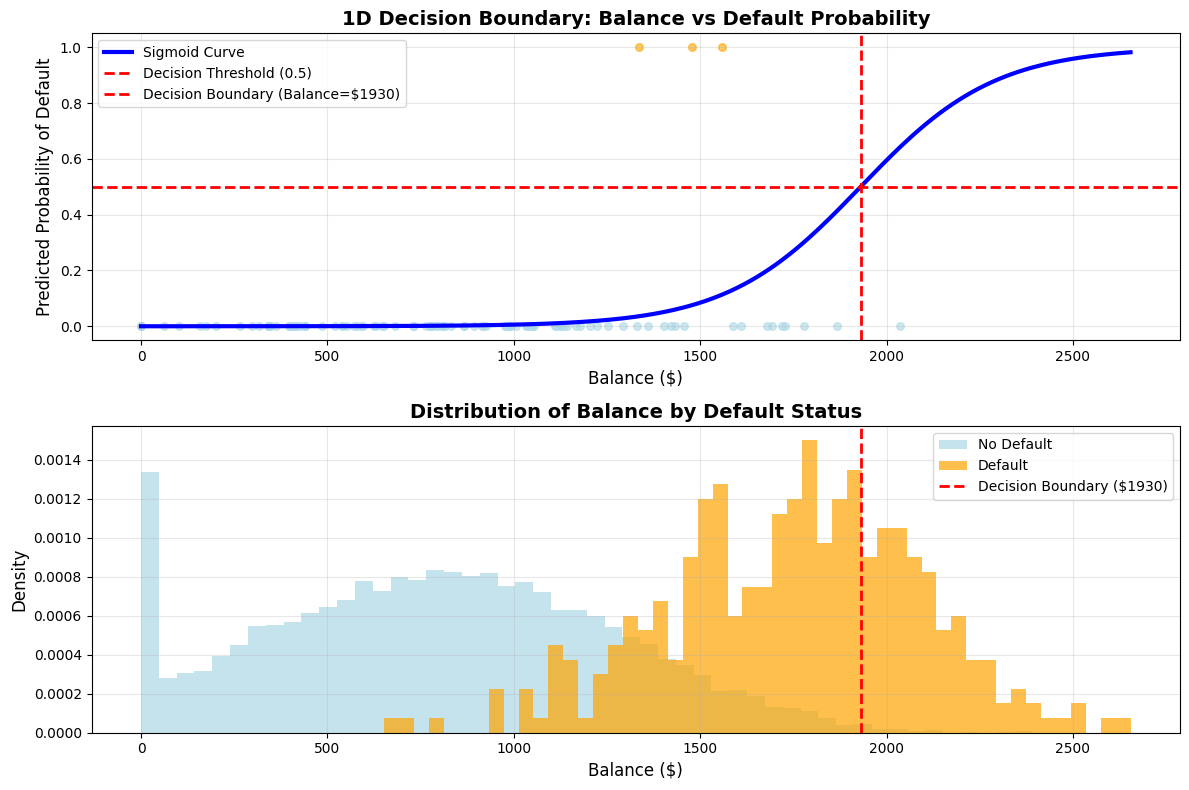


💡 INTERPRETATION:
• Customers with balance < $1930 are predicted as 'No Default'
• Customers with balance > $1930 are predicted as 'Default'
• The sigmoid curve shows how probability changes smoothly with balance


In [20]:
# 1D Decision Boundary: Logistic Regression with Balance only
print("🎯 1D DECISION BOUNDARY ANALYSIS")
print("="*50)

# Train a simple 1D logistic regression using only balance
X_balance = df[['balance']]
y_binary = df['default_binary']

# Split data for 1D model
X_balance_train, X_balance_test, y_balance_train, y_balance_test = train_test_split(
    X_balance, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Train 1D logistic regression
logistic_1d = LogisticRegression(random_state=42)
logistic_1d.fit(X_balance_train, y_balance_train)

print(f"1D Model Coefficient (Balance): {logistic_1d.coef_[0][0]:.6f}")
print(f"1D Model Intercept: {logistic_1d.intercept_[0]:.6f}")

# Calculate decision boundary (where probability = 0.5)
# 0.5 = 1 / (1 + exp(-(b0 + b1*x)))
# Solving: x = -b0/b1
decision_boundary_balance = -logistic_1d.intercept_[0] / logistic_1d.coef_[0][0]
print(f"Decision Boundary (Balance = $): {decision_boundary_balance:.2f}")

# Create range of balance values for smooth curve
balance_range = np.linspace(df['balance'].min(), df['balance'].max(), 300)
balance_range_reshaped = balance_range.reshape(-1, 1)

# Get predicted probabilities
prob_range = logistic_1d.predict_proba(balance_range_reshaped)[:, 1]

# Create the plot
plt.figure(figsize=(12, 8))

# Subplot 1: Sigmoid curve with decision boundary
plt.subplot(2, 1, 1)
plt.plot(balance_range, prob_range, 'b-', linewidth=3, label='Sigmoid Curve')
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
plt.axvline(x=decision_boundary_balance, color='red', linestyle='--', linewidth=2, 
           label=f'Decision Boundary (Balance=${decision_boundary_balance:.0f})')

# Add some sample points
sample_indices = np.random.choice(len(df), 100, replace=False)
for idx in sample_indices:
    color = 'orange' if df.iloc[idx]['default'] == 'Yes' else 'lightblue'
    plt.scatter(df.iloc[idx]['balance'], df.iloc[idx]['default_binary'], 
               color=color, alpha=0.6, s=30)

plt.xlabel('Balance ($)', fontsize=12)
plt.ylabel('Predicted Probability of Default', fontsize=12)
plt.title('1D Decision Boundary: Balance vs Default Probability', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Histogram showing distribution around decision boundary
plt.subplot(2, 1, 2)
no_default = df[df['default'] == 'No']['balance']
default = df[df['default'] == 'Yes']['balance']

plt.hist(no_default, bins=50, alpha=0.7, label='No Default', color='lightblue', density=True)
plt.hist(default, bins=50, alpha=0.7, label='Default', color='orange', density=True)
plt.axvline(x=decision_boundary_balance, color='red', linestyle='--', linewidth=2, 
           label=f'Decision Boundary (${decision_boundary_balance:.0f})')

plt.xlabel('Balance ($)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Balance by Default Status', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 INTERPRETATION:")
print(f"• Customers with balance < ${decision_boundary_balance:.0f} are predicted as 'No Default'")
print(f"• Customers with balance > ${decision_boundary_balance:.0f} are predicted as 'Default'")
print(f"• The sigmoid curve shows how probability changes smoothly with balance")


🎯 2D DECISION BOUNDARY ANALYSIS
2D Model Coefficients:
  Balance: 0.005624
  Income:  0.000015
  Intercept: -11.293740


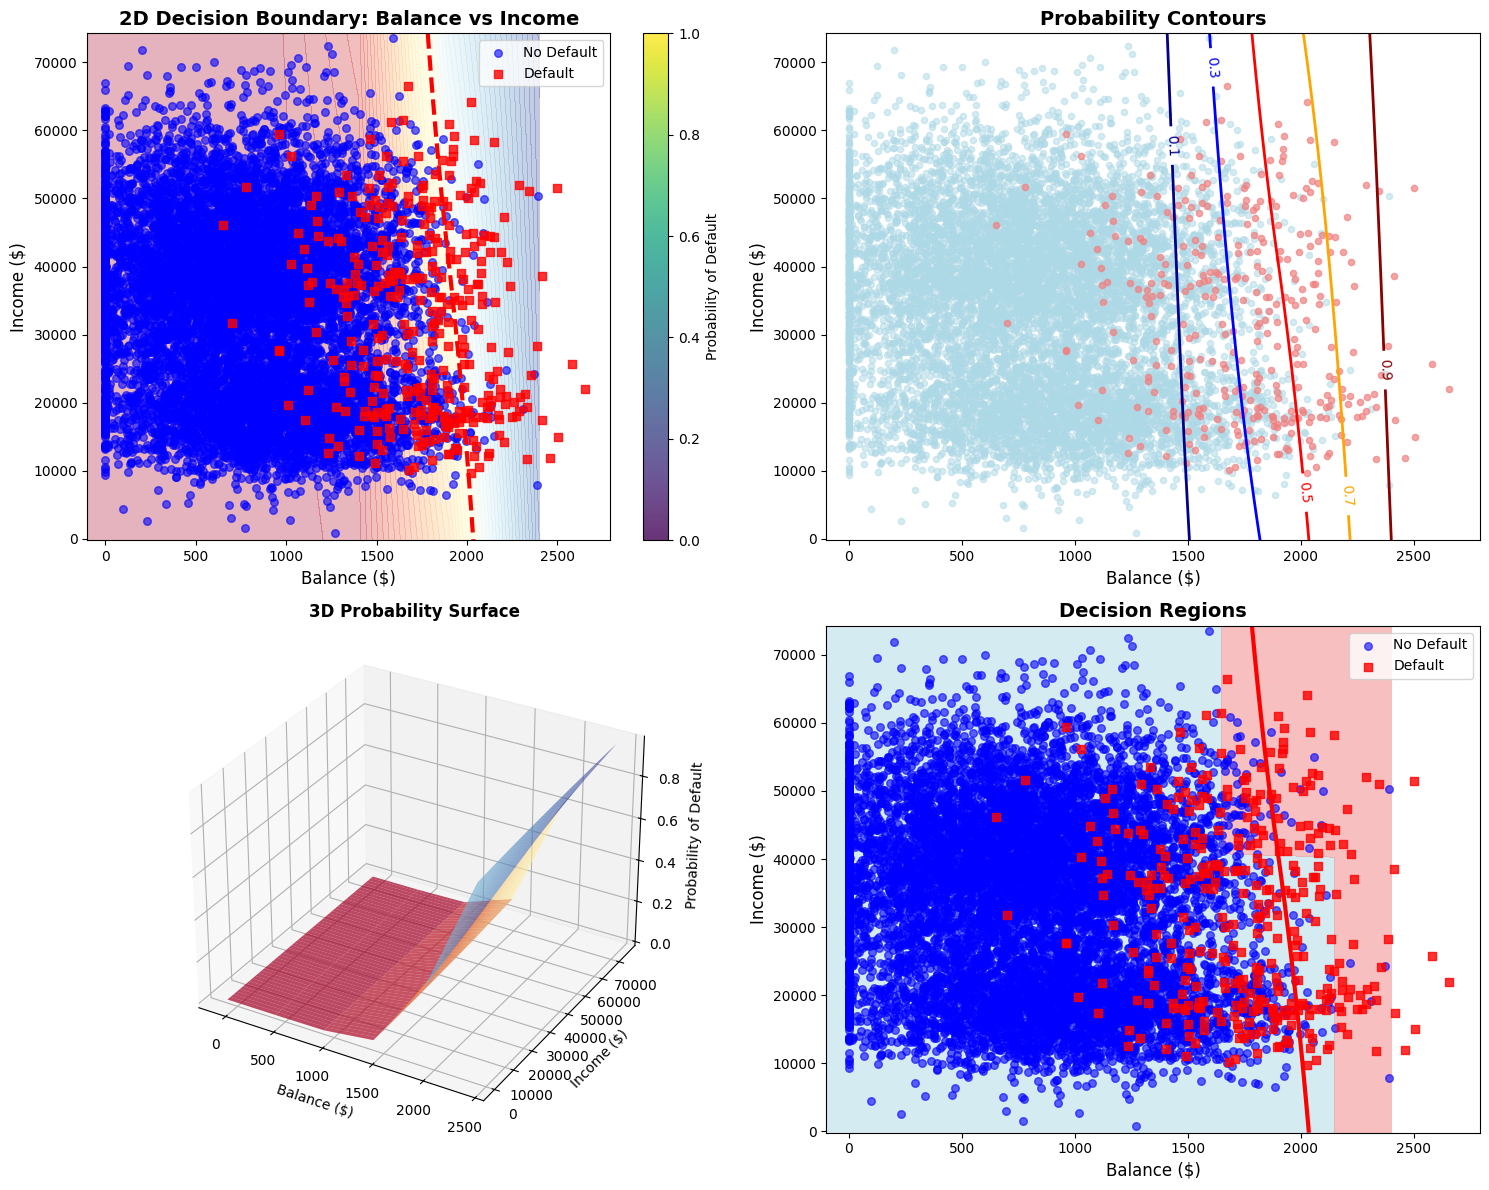


📐 DECISION BOUNDARY EQUATION:
The decision boundary occurs where: -11.294 + 0.005624×Balance + 0.000015×Income = 0
Rearranged: Income = 750365.0 + -373.664324×Balance

💡 INTERPRETATION:
• Red dashed line separates predicted classes
• Points above/right of line: Higher default probability
• Points below/left of line: Lower default probability
• The boundary is linear (straight line) in 2D space


In [21]:
# 2D Decision Boundary: Balance vs Income
print("\n🎯 2D DECISION BOUNDARY ANALYSIS")
print("="*50)

# Train 2D logistic regression using balance and income
X_2d = df[['balance', 'income']]
X_2d_train, X_2d_test, y_2d_train, y_2d_test = train_test_split(
    X_2d, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Train 2D logistic regression
logistic_2d = LogisticRegression(random_state=42)
logistic_2d.fit(X_2d_train, y_2d_train)

print(f"2D Model Coefficients:")
print(f"  Balance: {logistic_2d.coef_[0][0]:.6f}")
print(f"  Income:  {logistic_2d.coef_[0][1]:.6f}")
print(f"  Intercept: {logistic_2d.intercept_[0]:.6f}")

# Create a mesh for decision boundary visualization
h = 500  # step size in the mesh
balance_min, balance_max = df['balance'].min() - 100, df['balance'].max() + 100
income_min, income_max = df['income'].min() - 1000, df['income'].max() + 1000

xx, yy = np.meshgrid(np.arange(balance_min, balance_max, h),
                     np.arange(income_min, income_max, h))

# Get probability predictions for each point in the mesh
mesh_points = np.c_[xx.ravel(), yy.ravel()]
Z = logistic_2d.predict_proba(mesh_points)[:, 1]
Z = Z.reshape(xx.shape)

# Create the 2D decision boundary plot
plt.figure(figsize=(15, 12))

# Main plot: Decision boundary with contours
plt.subplot(2, 2, 1)
# Plot decision boundary (probability = 0.5)
plt.contour(xx, yy, Z, levels=[0.5], colors='red', linestyles='--', linewidths=3)
plt.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdYlBu')

# Plot data points
no_default_data = df[df['default'] == 'No']
default_data = df[df['default'] == 'Yes']

plt.scatter(no_default_data['balance'], no_default_data['income'], 
           c='blue', marker='o', alpha=0.6, s=30, label='No Default')
plt.scatter(default_data['balance'], default_data['income'], 
           c='red', marker='s', alpha=0.8, s=30, label='Default')

plt.xlabel('Balance ($)', fontsize=12)
plt.ylabel('Income ($)', fontsize=12)
plt.title('2D Decision Boundary: Balance vs Income', fontsize=14, fontweight='bold')
plt.legend()
plt.colorbar(label='Probability of Default')

# Subplot 2: Probability contours only
plt.subplot(2, 2, 2)
contour_plot = plt.contour(xx, yy, Z, levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
                          colors=['darkblue', 'blue', 'red', 'orange', 'darkred'], 
                          linewidths=2)
plt.clabel(contour_plot, inline=True, fontsize=10, fmt='%.1f')
plt.scatter(no_default_data['balance'], no_default_data['income'], 
           c='lightblue', alpha=0.5, s=20)
plt.scatter(default_data['balance'], default_data['income'], 
           c='lightcoral', alpha=0.7, s=20)
plt.xlabel('Balance ($)', fontsize=12)
plt.ylabel('Income ($)', fontsize=12)
plt.title('Probability Contours', fontsize=14, fontweight='bold')

# Subplot 3: 3D surface plot
ax = plt.subplot(2, 2, 3, projection='3d')
surf = ax.plot_surface(xx, yy, Z, cmap='RdYlBu', alpha=0.7)
ax.set_xlabel('Balance ($)')
ax.set_ylabel('Income ($)')
ax.set_zlabel('Probability of Default')
ax.set_title('3D Probability Surface', fontweight='bold')

# Subplot 4: Decision regions
plt.subplot(2, 2, 4)
# Create binary predictions
Z_binary = (Z >= 0.5).astype(int)
plt.contourf(xx, yy, Z_binary, levels=1, colors=['lightblue', 'lightcoral'], alpha=0.5)
plt.contour(xx, yy, Z, levels=[0.5], colors='red', linestyles='-', linewidths=3)

plt.scatter(no_default_data['balance'], no_default_data['income'], 
           c='blue', marker='o', alpha=0.6, s=30, label='No Default')
plt.scatter(default_data['balance'], default_data['income'], 
           c='red', marker='s', alpha=0.8, s=30, label='Default')

plt.xlabel('Balance ($)', fontsize=12)
plt.ylabel('Income ($)', fontsize=12)
plt.title('Decision Regions', fontsize=14, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

# Mathematical equation of the decision boundary
w0, w1, w2 = logistic_2d.intercept_[0], logistic_2d.coef_[0][0], logistic_2d.coef_[0][1]
print(f"\n📐 DECISION BOUNDARY EQUATION:")
print(f"The decision boundary occurs where: {w0:.3f} + {w1:.6f}×Balance + {w2:.6f}×Income = 0")
print(f"Rearranged: Income = {-w0/w2:.1f} + {-w1/w2:.6f}×Balance")
print(f"\n💡 INTERPRETATION:")
print(f"• Red dashed line separates predicted classes")
print(f"• Points above/right of line: Higher default probability") 
print(f"• Points below/left of line: Lower default probability")
print(f"• The boundary is linear (straight line) in 2D space")

In [22]:
# Decision Boundaries with Different Thresholds
print("\n🎯 DECISION BOUNDARIES AT DIFFERENT THRESHOLDS")
print("="*60)

# Show how decision boundary changes with different probability thresholds
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
thresholds_to_show = [0.3, 0.5, 0.7, 0.9]

for i, threshold in enumerate(thresholds_to_show):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    # Plot background probability surface
    contour_bg = ax.contourf(xx, yy, Z, levels=50, alpha=0.3, cmap='RdYlBu')
    
    # Plot decision boundary at current threshold
    ax.contour(xx, yy, Z, levels=[threshold], colors='red', linestyles='-', linewidths=3)
    
    # Plot data points
    ax.scatter(no_default_data['balance'], no_default_data['income'], 
              c='blue', marker='o', alpha=0.6, s=25, label='No Default')
    ax.scatter(default_data['balance'], default_data['income'], 
              c='red', marker='s', alpha=0.8, s=25, label='Default')
    
    # Classification regions based on threshold
    Z_thresh = (Z >= threshold).astype(int)
    ax.contourf(xx, yy, Z_thresh, levels=1, colors=['lightblue', 'lightcoral'], alpha=0.2)
    
    ax.set_xlabel('Balance ($)')
    ax.set_ylabel('Income ($)')
    ax.set_title(f'Threshold = {threshold}', fontweight='bold')
    if i == 0:
        ax.legend()

plt.suptitle('How Decision Boundaries Change with Different Thresholds', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"🔍 KEY OBSERVATIONS:")
print(f"• Lower thresholds (0.3): Decision boundary moves toward 'safer' region")
print(f"• Higher thresholds (0.9): Decision boundary moves toward 'riskier' region") 
print(f"• The boundary shape stays the same (linear) - only position changes")
print(f"• Changing threshold = changing the probability contour line we use for decisions")


🎯 DECISION BOUNDARIES AT DIFFERENT THRESHOLDS


🔍 KEY OBSERVATIONS:
• Lower thresholds (0.3): Decision boundary moves toward 'safer' region
• Higher thresholds (0.9): Decision boundary moves toward 'riskier' region
• The boundary shape stays the same (linear) - only position changes
• Changing threshold = changing the probability contour line we use for decisions


In [25]:
# Full 3-Feature Decision Boundary Analysis
print("\n🎯 3D DECISION BOUNDARY: ALL FEATURES")
print("="*50)

# Use the original 3-feature model we trained earlier
print(f"Full Model Coefficients:")
print(f"  Student:  {logistic.coef_[0][0]:.6f}")
print(f"  Balance:  {logistic.coef_[0][1]:.6f}") 
print(f"  Income:   {logistic.coef_[0][2]:.6f}")
print(f"  Intercept: {logistic.intercept_[0]:.6f}")

# Show decision boundary for students vs non-students separately
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for student_status in [0, 1]:
    ax = axes[student_status]
    
    # Create mesh for this student status
    mesh_student = np.full(xx.ravel().shape, student_status)
    mesh_3d = np.column_stack([mesh_student, xx.ravel(), yy.ravel()])
    
    # Get probability predictions
    Z_3d = logistic.predict_proba(mesh_3d)[:, 1].reshape(xx.shape)
    
    # Plot probability surface
    contour = ax.contourf(xx, yy, Z_3d, levels=50, alpha=0.3, cmap='RdYlBu')
    
    # Plot decision boundary (0.5 threshold)
    ax.contour(xx, yy, Z_3d, levels=[0.5], colors='red', linestyles='-', linewidths=3)
    
    # Plot data points for this student status
    student_filter = (df['student'] == student_status)
    no_default_student = df[student_filter & (df['default'] == 'No')]
    default_student = df[student_filter & (df['default'] == 'Yes')]
    
    ax.scatter(no_default_student['balance'], no_default_student['income'], 
              c='blue', marker='o', alpha=0.7, s=40, label='No Default')
    ax.scatter(default_student['balance'], default_student['income'], 
              c='red', marker='s', alpha=0.9, s=40, label='Default')
    
    student_label = "Student" if student_status == 1 else "Non-Student"
    ax.set_xlabel('Balance ($)')
    ax.set_ylabel('Income ($)')
    ax.set_title(f'Decision Boundary: {student_label}', fontweight='bold')
    ax.legend()
    
    # Add colorbar for first plot
    if student_status == 0:
        cbar = plt.colorbar(contour, ax=ax)
        cbar.set_label('Probability of Default')

plt.tight_layout()
plt.show()

# Calculate some example predictions to show the effect
examples = [
    {'student': 0, 'balance': 1000, 'income': 40000, 'description': 'Non-student, low balance, average income'},
    {'student': 1, 'balance': 1000, 'income': 40000, 'description': 'Student, low balance, average income'},
    {'student': 0, 'balance': 2000, 'income': 30000, 'description': 'Non-student, high balance, low income'},
    {'student': 1, 'balance': 2000, 'income': 30000, 'description': 'Student, high balance, low income'},
]

print(f"\n📊 EXAMPLE PREDICTIONS:")
print("-" * 80)
for ex in examples:
    X_example = np.array([[ex['student'], ex['balance'], ex['income']]])
    prob = logistic.predict_proba(X_example)[0, 1]
    prediction = "Default" if prob >= 0.5 else "No Default"
    
    print(f"• {ex['description']}")
    print(f"  Probability: {prob:.3f} → Prediction: {prediction}")
    print()

print(f"💡 KEY INSIGHTS:")
print(f"• Student status shifts the entire decision boundary")
print(f"• Students and non-students have different risk profiles at same balance/income")
print(f"• The model captures interactions between all three features")
print(f"• Decision boundary is still linear but exists in 3D space")


🎯 3D DECISION BOUNDARY: ALL FEATURES
Full Model Coefficients:
  Student:  -0.606192
  Balance:  0.005713
  Income:   -0.000002
  Intercept: -10.667191



📊 EXAMPLE PREDICTIONS:
--------------------------------------------------------------------------------
• Non-student, low balance, average income
  Probability: 0.007 → Prediction: No Default

• Student, low balance, average income
  Probability: 0.004 → Prediction: No Default

• Non-student, high balance, low income
  Probability: 0.670 → Prediction: Default

• Student, high balance, low income
  Probability: 0.525 → Prediction: Default

💡 KEY INSIGHTS:
• Student status shifts the entire decision boundary
• Students and non-students have different risk profiles at same balance/income
• The model captures interactions between all three features
• Decision boundary is still linear but exists in 3D space


In [26]:
# Summary: Decision Boundary Comparison
print("📋 DECISION BOUNDARY SUMMARY")
print("="*60)

# Create a comparison table
boundary_summary = {
    'Dimension': ['1D (Balance only)', '2D (Balance + Income)', '3D (All features)'],
    'Decision Boundary': [
        f'Balance = ${decision_boundary_balance:.0f}',
        f'Income = {-w0/w2:.1f} + {-w1/w2:.6f}×Balance',
        'Linear hyperplane in 3D space'
    ],
    'Interpretation': [
        'Single cutoff point',
        'Straight line in 2D',
        'Plane in 3D (shown as separate 2D slices)'
    ],
    'Complexity': ['Simplest', 'Moderate', 'Most complex'],
    'Flexibility': ['Limited', 'Better', 'Best']
}

summary_df = pd.DataFrame(boundary_summary)
print(summary_df.to_string(index=False))

print(f"\n🎓 MATHEMATICAL CONCEPTS:")
print(f"• Logistic regression always creates LINEAR decision boundaries")
print(f"• In 1D: boundary is a point")
print(f"• In 2D: boundary is a straight line") 
print(f"• In 3D: boundary is a flat plane")
print(f"• In higher dimensions: boundary is a hyperplane")

print(f"\n🔧 PRACTICAL IMPLICATIONS:")
print(f"• Linear boundaries work well when classes are linearly separable")
print(f"• If data has complex, non-linear patterns, consider:")
print(f"  - Polynomial features")
print(f"  - Non-linear algorithms (SVM with RBF, Random Forest, Neural Networks)")
print(f"  - Feature engineering to capture non-linear relationships")

print(f"\n⚙️ MODEL EQUATION SUMMARY:")
print(f"P(default=1) = 1 / (1 + exp(-(β₀ + β₁×student + β₂×balance + β₃×income)))")
print(f"Where:")
print(f"  β₀ = {logistic.intercept_[0]:.4f} (intercept)")
print(f"  β₁ = {logistic.coef_[0][0]:.4f} (student coefficient)")
print(f"  β₂ = {logistic.coef_[0][1]:.6f} (balance coefficient)")
print(f"  β₃ = {logistic.coef_[0][2]:.6f} (income coefficient)")

📋 DECISION BOUNDARY SUMMARY
            Dimension                       Decision Boundary                            Interpretation   Complexity Flexibility
    1D (Balance only)                         Balance = $1930                       Single cutoff point     Simplest     Limited
2D (Balance + Income) Income = 750365.0 + -373.664324×Balance                       Straight line in 2D     Moderate      Better
    3D (All features)           Linear hyperplane in 3D space Plane in 3D (shown as separate 2D slices) Most complex        Best

🎓 MATHEMATICAL CONCEPTS:
• Logistic regression always creates LINEAR decision boundaries
• In 1D: boundary is a point
• In 2D: boundary is a straight line
• In 3D: boundary is a flat plane
• In higher dimensions: boundary is a hyperplane

🔧 PRACTICAL IMPLICATIONS:
• Linear boundaries work well when classes are linearly separable
• If data has complex, non-linear patterns, consider:
  - Polynomial features
  - Non-linear algorithms (SVM with RBF, Rando